In [1]:
import os

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

import albumentations as A
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import segmentation_models_pytorch as smp

from loguru import logger

/home/pyml/anaconda3/envs/objrecognition/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# constants
ARCH = "FPN"
ENCODER_NAME = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
batch_size = 16
augmentation_mode = "light"  # or heavy
num_epochs = 100


CLASS_NAMES = [
    "background", "sky", "building", "pole",
    "road", "pavement", "tree", "signsymbol",
    "fence", "car", "pedestrian", "bicyclist", 
]

# preprocessing parameters:
smp.encoders.get_preprocessing_params(ENCODER_NAME)

{'input_space': 'RGB',
 'input_range': [0, 1],
 'mean': [0.485, 0.456, 0.406],
 'std': [0.229, 0.224, 0.225]}

In [3]:
class MySegmentDataset(Dataset):
    def __init__(
            self,
            csv_file,
            transforms=None,
            split="train",
        ):
        self.transforms = transforms
        self.split = split
        df = pd.read_csv(csv_file)
        df_selected = df[df["split"] == split]
        self.img_files = df_selected["imagepath"].values
        self.mask_files = df_selected["maskpath"].values

        self.preprocessing_fn = smp.encoders.get_preprocessing_fn(
            ENCODER_NAME, ENCODER_WEIGHTS
        )

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        mask_path = self.mask_files[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transforms:
            output_dict = self.transforms(image=image, mask=mask)
            image = output_dict["image"]
            mask = output_dict["mask"]

        # normalize image
        image = self.preprocessing_fn(image)
        image = image.transpose(2, 0, 1)
        mask = mask[np.newaxis, :, :]

        return {
            "image": torch.FloatTensor(image),
            "mask": torch.LongTensor(mask)
        }
    

img: torch.Size([3, 360, 480]) min: -2.12 max: 2.64, msk: torch.Size([1, 360, 480]) unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11]
img: torch.Size([3, 360, 480]) min: -2.12 max: 2.64, msk: torch.Size([1, 360, 480]) unique values: [ 0  1  2  3  4  5  6  9 10]
img: torch.Size([3, 360, 480]) min: -2.12 max: 2.64, msk: torch.Size([1, 360, 480]) unique values: [ 0  1  2  3  4  6  7  9 10]
img: torch.Size([3, 360, 480]) min: -2.12 max: 2.64, msk: torch.Size([1, 360, 480]) unique values: [ 0  1  2  3  4  5  6  7  8  9 10]


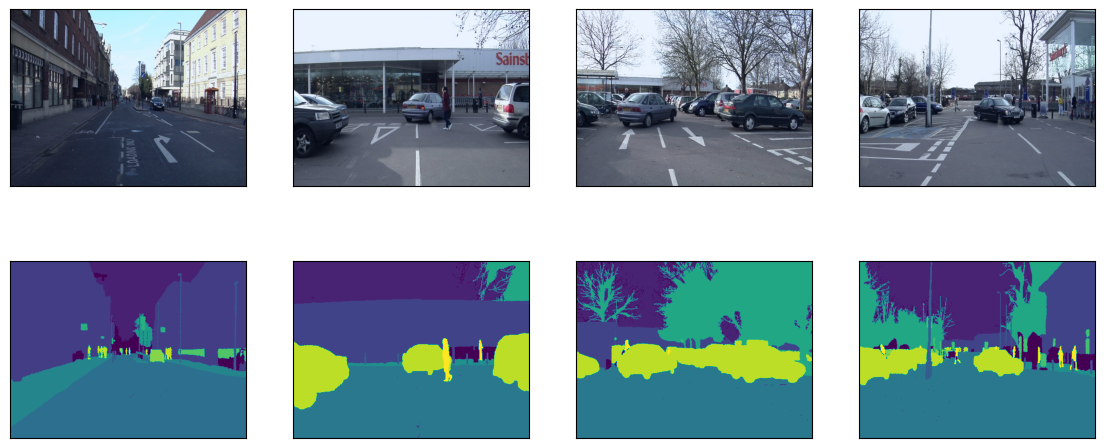

In [4]:
# build a dataset
train_dataset = MySegmentDataset(
    csv_file="data/data.csv",
    transforms=None,
    split="train"
)


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 6))
for i in range(4):
    #img, msk = train_dataset[i]
    sample = train_dataset[i]
    img, msk = sample["image"], sample["mask"]
    print(
        f"img: {img.shape} min: {img.min():.2f} max: {img.max():.2f}, "
        f"msk: {msk.shape} unique values: {np.unique(msk)}"
    )
    img = img.permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())
    axes[0, i].imshow(img)
    axes[1, i].imshow(msk[0])
    
[[ax.set_xticks([]), ax.set_yticks([])]  for ax in axes.flatten()]
plt.show()

In [5]:

# Reference: 
# https://github.com/qubvel-org/segmentation_models.pytorch
# /blob/main/examples/camvid_segmentation_multiclass.ipynb
def get_train_augmentation(augmentation_mode="light"):
    if augmentation_mode == "light":
        train_transform = [
            A.PadIfNeeded(min_height=320, min_width=320, always_apply=True),
            A.RandomCrop(height=320, width=320, always_apply=True),
            A.HorizontalFlip(p=0.5),
        ]
        return A.Compose(train_transform)
    # heavy augmentation:
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(
            scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0
        ),
        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True),
        A.RandomCrop(height=320, width=320, always_apply=True),
        A.GaussNoise(p=0.2),
        A.Perspective(p=0.5),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(train_transform)


def get_val_augmentation():
    """Add paddings to make image shape divisible by 32"""
    val_transform = [
        A.PadIfNeeded(480, 480),
        A.CenterCrop(480, 480)
    ]
    return A.Compose(val_transform)

img: torch.Size([3, 320, 320]) min: -2.12 max: 2.64, msk: torch.Size([1, 320, 320]) unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11]
img: torch.Size([3, 320, 320]) min: -2.10 max: 2.64, msk: torch.Size([1, 320, 320]) unique values: [ 0  1  2  3  4  5  9 10]
img: torch.Size([3, 320, 320]) min: -2.12 max: 2.64, msk: torch.Size([1, 320, 320]) unique values: [ 0  1  2  3  4  6  7  9 10]
img: torch.Size([3, 320, 320]) min: -2.12 max: 2.64, msk: torch.Size([1, 320, 320]) unique values: [ 0  1  2  3  4  5  6  7  8  9 10]
img: torch.Size([3, 320, 320]) min: -2.08 max: 2.64, msk: torch.Size([1, 320, 320]) unique values: [ 0  1  2  3  4  5  6  7  9 10]


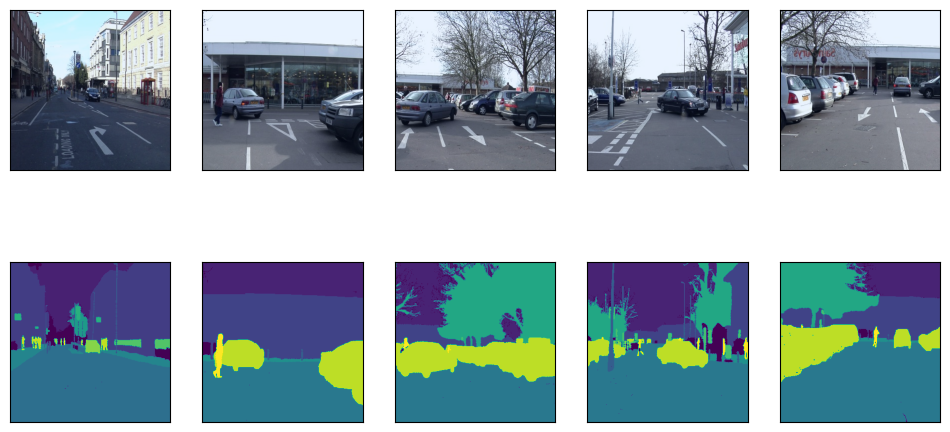

In [6]:
# build a dataset
train_dataset = MySegmentDataset(
    csv_file="data/data.csv",
    transforms=get_train_augmentation("light"),
    split="train"
)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
for i in range(5):
    #img, msk = train_dataset[i]
    sample = train_dataset[i]
    img, msk = sample["image"], sample["mask"]
    print(
        f"img: {img.shape} min: {img.min():.2f} max: {img.max():.2f}, "
        f"msk: {msk.shape} unique values: {np.unique(msk)}"
    )
    img = img.numpy().transpose(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())
    axes[0, i].imshow(img)
    axes[1, i].imshow(msk[0])

    
[[ax.set_xticks([]), ax.set_yticks([])]  for ax in axes.flatten()]
plt.show()

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SegmentationModel(nn.Module):
    def __init__(
            self,
            arch,
            encoder_name,
            encoder_weights,
            in_channels,
            out_classes
        ):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=out_classes,
        )

        # setup normalization
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer(
            "mean", torch.tensor(params["mean"]).view(1, 3, 1, 1)
        )
        self.register_buffer(
            "std", torch.tensor(params["std"]).view(1, 3, 1, 1)
        )

    def forward(self, image):
        image = (image - self.mean) / self.std
        return self.model(image)
    
    def count_parameters(self):
        return sum(
            p.numel() for p in self.parameters() if p.requires_grad
        )

# build model
model = SegmentationModel(
    arch=ARCH,
    encoder_name=ENCODER_NAME,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3,
    out_classes=len(CLASS_NAMES)
)
model.to(device)

# count model parameters
logger.info(f"Model has {model.count_parameters()} trainable parameters")

2024-10-04 23:16:17.328 | INFO     | __main__:<module>:50 - Model has 23156812 trainable parameters


In [8]:

train_dataset = MySegmentDataset(
    csv_file="data/data.csv",
    transforms=get_train_augmentation(),
    split="train"
)
logger.info(f"Train dataset has {len(train_dataset)} samples")

val_dataset = MySegmentDataset(
    csv_file="data/data.csv",
    transforms=get_val_augmentation(),
    split="val"
)
logger.info(f"Validation dataset has {len(val_dataset)} samples")

train_loader = DataLoader(
    train_dataset, batch_size=batch_size,
    shuffle=True, num_workers=4,
)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size,
    shuffle=False, num_workers=4,
    drop_last=True,
)

batch = next(iter(train_loader))
print(f"batch images: {batch['image'].shape}, masks: {batch['mask'].shape}")
print(f"batch images: {batch['image'].dtype}, masks: {batch['mask'].dtype}")

2024-10-04 23:16:17.334 | INFO     | __main__:<module>:6 - Train dataset has 367 samples
2024-10-04 23:16:17.335 | INFO     | __main__:<module>:13 - Validation dataset has 101 samples


batch images: torch.Size([16, 3, 320, 320]), masks: torch.Size([16, 1, 320, 320])
batch images: torch.float32, masks: torch.int64


In [9]:
batch_val = next(iter(val_loader))
print(
    f"batch images: {batch_val['image'].shape}, "
    f"masks: {batch_val['mask'].shape}"
)

batch images: torch.Size([16, 3, 480, 480]), masks: torch.Size([16, 1, 480, 480])


In [10]:
# training step
def training_step(
        model,
        batch,
        criterion,
        optimizer,
        scheduler,
        device
    ):
    optimizer.zero_grad()    
    model.train()
    images = batch["image"].to(device)
    masks = batch["mask"].to(device)
    masks = masks.squeeze(1)

    logits = model(images)
    loss = criterion(logits, masks)
    loss.backward()
    optimizer.step()
    scheduler.step()

    probas = torch.softmax(logits.detach(), 1)
    pred_mask = probas.argmax(dim=1)

    # calculate metrics
    tp, fp, fn, tn = smp.metrics.get_stats(
        pred_mask, masks,
        mode="multiclass", num_classes=len(CLASS_NAMES)
    )

    return {
        "loss": loss.item(),
        "fp": fp, "tp": tp,
        "fn": fn, "tn": tn
    }

# validation function
def validation_step(
        model,
        batch,
        criterion,
        device
    ):
    model.eval()
    images = batch["image"].to(device)
    masks = batch["mask"].to(device)
    masks = masks.squeeze(1)

    with torch.no_grad():
        logits = model(images)
    loss = criterion(logits, masks)

    probas = torch.softmax(logits, 1)
    pred_mask = probas.argmax(dim=1)

    # calculate metrics
    tp, fp, fn, tn = smp.metrics.get_stats(
        pred_mask, masks,
        mode="multiclass", num_classes=len(CLASS_NAMES)
    )

    return {
        "loss": loss.item(),
        "fp": fp, "tp": tp,
        "fn": fn, "tn": tn
    }


def aggregate_metrics(metrics_list, stage):
    fp = torch.cat([m["fp"] for m in metrics_list], dim=0)
    tp = torch.cat([m["tp"] for m in metrics_list], dim=0)
    fn = torch.cat([m["fn"] for m in metrics_list], dim=0)
    tn = torch.cat([m["tn"] for m in metrics_list], dim=0)

    per_image_iou = smp.metrics.iou_score(
        tp, fp, fn, tn, reduction="micro-imagewise"
    )

    dataset_iou = smp.metrics.iou_score(
        tp, fp, fn, tn, reduction="micro"
    )

    return {
        f"{stage}_per_image_iou": per_image_iou,
        f"{stage}_dataset_iou": dataset_iou
    }

In [ ]:
t_max = num_epochs * len(train_loader)

optimizer = optim.Adam(model.parameters(), lr=2e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=t_max, eta_min=1e-5
)

criterion = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)

metrics = []
for epoch in range(num_epochs):
    training_outputs = []
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        loop.set_description("Epoch: {}/{}".format(epoch + 1, num_epochs))
        outputs = training_step(
            model, batch, criterion, optimizer, scheduler, device
        )
        training_outputs.append(outputs)
        loop.set_postfix(loss=outputs["loss"])

    trn_metrics = aggregate_metrics(training_outputs, "train")
    # run validation
    val_outputs = []
    loop = tqdm(val_loader, leave=True)
    for batch in loop:
        loop.set_description("Validation")
        outputs = validation_step(model, batch, criterion, device)
        val_outputs.append(outputs)
        loop.set_postfix(loss=outputs["loss"])
    val_metrics = aggregate_metrics(val_outputs, "valid")

    metrics.append({**trn_metrics, **val_metrics})


  0%|          | 0/23 [00:00<?, ?it/s]

Validation:  83%|████████▎ | 5/6 [00:00<00:00, 10.14it/s, loss=0.272]

## Evaluation on the testset

In [12]:
test_outputs = []
test_dataset = MySegmentDataset(
    csv_file="data/data.csv",
    transforms=get_val_augmentation(),
    split="test"
)

test_loader = DataLoader(
    test_dataset, batch_size=10,
    shuffle=False, num_workers=4,
    drop_last=False,
)

for batch in tqdm(test_loader):
    outputs = validation_step(model, batch, criterion, device)
    test_outputs.append(outputs)

test_metrics = aggregate_metrics(test_outputs, "test")
logger.info(
    f"Test avg_iou: {test_metrics['test_dataset_iou']:.4f}"
)

100%|██████████| 24/24 [00:01<00:00, 18.41it/s]
2024-10-04 23:13:32.676 | INFO     | __main__:<module>:19 - Test avg_iou: 0.4431


In [13]:
# visualize predicitons
batch = next(iter(test_loader))
images = batch["image"].to(device)

logits = model(images)
probas = torch.softmax(logits, 1)
pred_mask = probas.argmax(dim=1)



In [14]:
save_model_dir = "segmentation_model/"

smp_model = model.model
smp_model.save_pretrained(
    save_directory=save_model_dir,
    metrics=test_metrics,
    dataset="coco-subset",
)

TypeError: Object of type Tensor is not JSON serializable